In [251]:
import pandas as pd
import numpy as np
import pypsa
import os
import matplotlib.pyplot as plt
import glob

In [252]:
run_dict = {
            "Baseline" : "results/Baseline_128n_3H/",
            "Tech" : "results/Tech_128n_3H/",
            "Life" : "results/Life_128n_3H/",
            "Tango" : "results/Tango_128n_3H_netzero/"
            }

In [253]:
#net_dict = {}
#for k in run_dict.keys():
#    print(k)
#    netdir = glob.glob(run_dict[k]+"/postnetworks/*.nc")[0]
#    net_dict[k] = pypsa.Network(netdir)

In [254]:
def cycling_shift(df, steps=1):
    """Cyclic shift on index of pd.Series|pd.DataFrame by number of steps"""
    df = df.copy()
    new_index = np.roll(df.index, steps)
    df.values[:] = df.reindex(index=new_index).values
    return df

In [255]:
FLATTEN = True
FLATSCALE = 0.5

def flatten_loads(n):
    # electricity
    # land transport EV
    # all heats
    # 
    
    heat_systems = [
        "residential rural",
        "services rural",
        "residential urban decentral",
        "services urban decentral",
        "urban central"
    ]
    

In [336]:
n = pypsa.Network("results/Baseline_128n_3H/prenetworks/elec_sc_LTS_Baseline_s_128_lvopt__Co2L0p10-3H-T-H-B-I-A-seq1e9_2050.nc")
n.loads.carrier.unique()
norig = n.copy()


Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 0], imported network file PyPSA version [0, 19, 3].

INFO:pypsa.io:Imported network elec_sc_LTS_Baseline_s_128_lvopt__Co2L0p10-3H-T-H-B-I-A-seq1e9_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [257]:
def flatten(n,carrier):
# timeseries becomes: timeseries*(1-FLATSCALE) + year_avg*FLATSCALE
    for ct in n.buses.country.dropna().unique():
        # TODO map onto n.bus.country
        loads_i = n.loads.index[(n.loads.index.str[:2] == ct) & (n.loads.carrier == carrier)]
        loads_i = n.loads_t.p_set.columns.intersection(loads_i)
        #if not loads_i in n.loads_t.p_set.columns : continue
        if n.loads_t.p_set[loads_i].empty: continue
        if FLATTEN:
            #print(loads_i)
            avg = pd.DataFrame(index  = n.loads_t.p_set[loads_i].index, columns = n.loads_t.p_set[loads_i].columns)
            for c in avg.columns:
                avg.loc[:,c] = n.loads_t.p_set[c].multiply(n.snapshot_weightings["generators"]).sum()/8760

            n.loads_t.p_set[loads_i] = FLATSCALE*avg + (1-FLATSCALE)*n.loads_t.p_set[loads_i]
            
def smoothen(df,window):
    dfc = df.copy()
    dfc_tot = dfc
    for i in range(1,int(window/2)+1):
        dfc_tot = dfc_tot + cycling_shift(dfc,i)
        #print(i,dfc_tot.sum())
    for i in range(1,int((window-1)/2)+1):
        dfc_tot = dfc_tot + cycling_shift(dfc,-1*i)
        #print(-1*i,dfc_tot.sum())
    dfc_tot = dfc_tot / window
    return dfc_tot

def flatten_heat(n,carrier):
# Performs moving average over a period of FLATSCALE*year (i.e., 0.08333333 ~= 1 month window)
    for ct in n.buses.country.dropna().unique():
        # TODO map onto n.bus.country
        loads_i = n.loads.index[(n.loads.index.str[:2] == ct) & (n.loads.carrier == carrier)]
        loads_i = n.loads_t.p_set.columns.intersection(loads_i)
        #if not loads_i in n.loads_t.p_set.columns : continue
        if n.loads_t.p_set[loads_i].empty: continue
        if FLATTEN:        
            n.loads_t.p_set[loads_i] = smoothen(n.loads_t.p_set[loads_i],n.snapshots.size*FLATSCALE)

def flatten_all_heat(n):
    print("Reducing all heat peaks by factor of ", FLATSCALE)
    carriers = n.loads.carrier.unique()
    heat_names = [c for c in carriers if "heat" in c]
    for h in heat_names:
        print(h)
        flatten_heat(n,h)
        
def flatten_all_elec(n):
    print("Reducing all electricity peaks by factor of ", FLATSCALE)
    carriers = n.loads.carrier.unique()
    elec_names = [c for c in carriers if "electric" in c or "EV" in c]
    for e in elec_names:
        print(e)
        flatten(n,e)

In [258]:
n.loads.carrier.unique()


array(['electricity', 'land transport EV', 'land transport fuel cell',
       'land transport oil', 'land transport oil emissions',
       'residential rural heat', 'services rural heat',
       'residential urban decentral heat',
       'services urban decentral heat', 'urban central heat',
       'solid biomass for industry', 'gas for industry',
       'H2 for industry', 'H2 for shipping', 'shipping oil',
       'shipping oil emissions', 'naphtha for industry',
       'kerosene for aviation', 'oil emissions',
       'low-temperature heat for industry', 'industry electricity',
       'process emissions', 'agriculture electricity', 'agriculture heat',
       'agriculture machinery electric', 'agriculture machinery oil',
       'agriculture machinery oil emissions'], dtype=object)

In [ ]:
buses = ["GB0 2 residential rural heat"]#,"GB0 1 residential rural heat"]

plt.plot(n.loads_t.p_set[buses][:])
print(n.loads_t.p_set[buses][:].sum())

flatten_all_heat(n)

plt.plot(n.loads_t.p_set[buses][:])
print(n.loads_t.p_set[buses][:].sum())


Load
GB0 2 residential rural heat    0.639263
dtype: float64


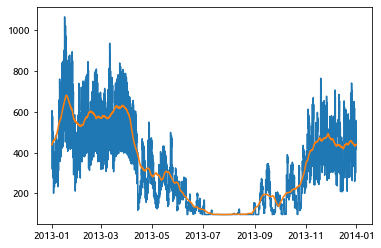

In [337]:
FLATSCALE = 0.05

buses = ["GB0 2 residential rural heat"]#,"GB0 1 residential rural heat"]

plt.plot(n.loads_t.p_set[buses][:])

#s = smoothen(n.loads_t.p_set[buses],8760/3/4)
flatten_heat(n,"residential rural heat")

#smoothen(n,"residential urban decentral heat")

#plt.plot(n.loads_t.p_set["FR1 0 residential urban decentral heat"][:])

plt.plot(n.loads_t.p_set[buses][:])
print(n.loads_t.p_set[buses].max()/norig.loads_t.p_set[buses].max())


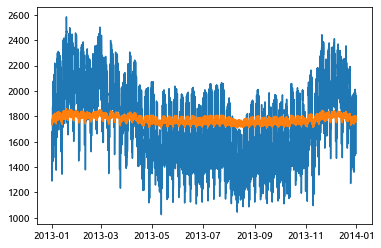

In [317]:
FLATSCALE = 0.9

norig = n.copy()


flatten(n,"electricity")

plt.plot(norig.loads_t.p_set["FR1 0"])

plt.plot(n.loads_t.p_set["FR1 0"])


#n.loads_t.p_set#['GB0 11 urban central heat']
#loads_i = n.loads.index[(n.loads.index.str[:2] == "GB") & (n.loads.carrier == "urban central heat")]
#n.loads_t.p_set.columns.intersection(loads_i)


In [320]:
def get_peaks(n,carrier,nodes="all"):
    loads_i = n.loads.index[(n.loads.carrier == carrier)]
    
    if nodes=="all":
        loads_i = loads_i
    elif type(nodes)==str:
        loads_i = [i for i in loads_i if nodes in i]
    elif type(nodes)==list:
        loads_i = [i for i in loads_i if any(n in i for n in nodes)]
    else:
        loads_i = 0
    return n.loads_t.p_set[loads_i].max()

def get_peak_ratios(n,nflat,carrier,nodes="all"):
    p=get_peaks(n,carrier,nodes)
    pflat=get_peaks(nflat,carrier,nodes)
    return pflat/p

get_peak_ratios(norig,n,"residential rural heat","FR")

Load
FR1 0 residential rural heat     0.644686
FR1 1 residential rural heat     0.571015
FR1 10 residential rural heat    0.572223
FR1 11 residential rural heat    0.540027
FR1 12 residential rural heat    0.633223
FR1 13 residential rural heat    0.620580
FR1 14 residential rural heat    0.606362
FR1 15 residential rural heat    0.535615
FR1 16 residential rural heat    0.584232
FR1 17 residential rural heat    0.546521
FR1 18 residential rural heat    0.576450
FR1 2 residential rural heat     0.575007
FR1 3 residential rural heat     0.581752
FR1 4 residential rural heat     0.566360
FR1 5 residential rural heat     0.552151
FR1 6 residential rural heat     0.658046
FR1 7 residential rural heat     0.595011
FR1 8 residential rural heat     0.653301
FR1 9 residential rural heat     0.581516
dtype: float64

In [323]:
print(n.loads_t.p_set["GB0 2 residential rural heat"].sum())
print(norig.loads_t.p_set["GB0 2 residential rural heat"].sum())

985075.2346479462
985075.2346479463


In [203]:

#plt.plot(n.loads_t.p_set["FR1 0"])

for ct in n.buses.country.dropna().unique():
    # TODO map onto n.bus.country
    loads_i = n.loads.index[(n.loads.index.str[:2] == ct) & (n.loads.carrier == "electricity")]
    if n.loads_t.p_set[loads_i].empty: continue
    if FLATTEN and ct == "FR":
        #print(loads_i)
        minim = pd.DataFrame(index  = n.loads_t.p_set[loads_i].index, columns = n.loads_t.p_set[loads_i].columns)
        for c in minim.columns:
            minim.loc[:,c] = n.loads_t.p_set[c].min()

        #n.loads_t.p_set[loads_i] = minim + (1-FLATSCALE)*(n.loads_t.p_set[loads_i]-minim)


minim

#n.snapshot_weightings["generators"].divide(8760)
#plt.plot(n.loads_t.p_set["FR1 0"])
#n.loads_t.p_set[loads_i]

#n.loads_t.p_set[loads_i] *= factor

Load,FR1 0,FR1 1,FR1 10,FR1 11,FR1 12,FR1 13,FR1 14,FR1 15,FR1 16,FR1 17,FR1 18,FR1 2,FR1 3,FR1 4,FR1 5,FR1 6,FR1 7,FR1 8,FR1 9
snapshot,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
2013-01-01 03:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
2013-01-01 06:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
2013-01-01 09:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
2013-01-01 12:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
2013-12-31 12:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235
2013-12-31 15:00:00,1591.916647,1134.016762,1677.460196,1608.578782,1198.998208,2111.448247,1274.7446,2089.894439,989.615031,2050.90841,1026.26694,6147.763096,1078.627317,1936.99581,1107.788253,1180.104587,987.316154,1131.519077,930.887235


array(['electricity', 'land transport EV', 'land transport fuel cell',
       'land transport oil', 'land transport oil emissions',
       'residential rural heat', 'services rural heat',
       'residential urban decentral heat',
       'services urban decentral heat', 'urban central heat',
       'solid biomass for industry', 'gas for industry',
       'H2 for industry', 'H2 for shipping', 'shipping oil',
       'shipping oil emissions', 'naphtha for industry',
       'kerosene for aviation', 'oil emissions',
       'low-temperature heat for industry', 'industry electricity',
       'process emissions', 'agriculture electricity', 'agriculture heat',
       'agriculture machinery electric', 'agriculture machinery oil',
       'agriculture machinery oil emissions'], dtype=object)

In [7]:
n = net_dict["Baseline"]
for ct in n.buses.country.dropna().unique():
        # TODO map onto n.bus.country
        loads_i = n.loads.index[(n.loads.index.str[:2] == ct) & (n.loads.carrier == "electricity")]
        

# Test on actual pypsa networks

In [339]:
nflat = pypsa.Network("results/test_flattening/prenetworks/elec_sc_noscaling_s_128_lv1.0__Co2L0p00-1H-T-H-B-I-A_2050.nc")
n =  pypsa.Network("results/test_noflattening/prenetworks/elec_sc_noscaling_s_128_lv1.0__Co2L0p00-1H-T-H-B-I-A_2050.nc")



INFO:pypsa.io:Imported network elec_sc_noscaling_s_128_lv1.0__Co2L0p00-1H-T-H-B-I-A_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_sc_noscaling_s_128_lv1.0__Co2L0p00-1H-T-H-B-I-A_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [340]:
get_peak_ratios(n,nflat,"residential rural heat","FR")

Load
FR1 0 residential rural heat     0.623721
FR1 1 residential rural heat     0.574766
FR1 10 residential rural heat    0.552149
FR1 11 residential rural heat    0.543371
FR1 12 residential rural heat    0.548056
FR1 13 residential rural heat    0.654852
FR1 14 residential rural heat    0.629370
FR1 15 residential rural heat    0.644157
FR1 16 residential rural heat    0.585058
FR1 17 residential rural heat    0.563641
FR1 18 residential rural heat    0.594547
FR1 2 residential rural heat     0.558509
FR1 3 residential rural heat     0.601821
FR1 4 residential rural heat     0.592678
FR1 5 residential rural heat     0.619965
FR1 6 residential rural heat     0.561559
FR1 7 residential rural heat     0.581775
FR1 8 residential rural heat     0.612095
FR1 9 residential rural heat     0.647427
dtype: float64

In [341]:
get_peak_ratios(n,nflat,"electricity","FR")

Load
FR1 0     0.678863
FR1 1     0.667592
FR1 10    0.657241
FR1 11    0.671914
FR1 12    0.654306
FR1 13    0.663803
FR1 14    0.666735
FR1 15    0.679300
FR1 16    0.665997
FR1 17    0.681031
FR1 18    0.663548
FR1 2     0.657665
FR1 3     0.670988
FR1 4     0.653513
FR1 5     0.677421
FR1 6     0.643633
FR1 7     0.691597
FR1 8     0.631739
FR1 9     0.643318
dtype: float64